In [744]:
"""CREDIT TO PRUTHA ANNADATE, https://www.kaggle.com/code/pruthaannadate/catboost-march-machine-learning-mania-25"""

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, f1_score, accuracy_score, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier

from keras.layers import Dense
from keras.models import Sequential

import warnings
warnings.filterwarnings(action='ignore')

# Helper functions

In [9]:
def load_df_dict(path='march-machine-learning-mania-2025/'):
    data_dict = {}
    
    for fname in os.listdir(path):
        data_dict[fname.split('.')[0]] = pd.read_csv(path + fname)
        
    return data_dict

In [746]:
# fix feature set logic so you dont need to pass both W and L, append at the end
# add models iteratively 

def bracketology(dataset, feature_set=['WTeamID', 'LTeamID'], model_name='catboost'):
    
    model_directory = {
        'catboost': CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=200),
        'xgb': XGBClassifier(enable_categorical=True),
        'lr': LogisticRegression(),
        'hgb': HistGradientBoostingClassifier()
    }

    result_dict = {}

    X = dataset[feature_set]
    y = dataset['result']
    
    k_strat = StratifiedKFold(n_splits=4, shuffle=False)
    folds = k_strat.split(X, y)

    auc = []
    accuracy = []
    brier_score = []

    for train, test in folds:
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.values[train], y.values[test]

        model = model_directory[model_name]
        model.fit(X_train, y_train)

        y_preds = model.predict(X_test)
        y_probs = model.predict_proba(X_test)
        auc.append(roc_auc_score(y_test, y_probs[:,1]))
        accuracy.append(accuracy_score(y_test, y_preds))
        brier_score.append(brier_score_loss(y_test, y_probs[:,1]))
    
    model.fit(X, y)

    result_dict['model_name'] = model_name
    result_dict['model'] = model
    result_dict['auc'] = np.average(auc)
    result_dict['accuracy'] = np.average(accuracy)
    result_dict['brier_score'] = np.average(brier_score)
    
    return result_dict
            

In [732]:
# de-duping first - order of dupe removal doesn't matter bc 
def agg_team_stats(team_id, master_df, seed_df):
    team_df = master_df[(master_df.WTeamID == team_id) | (master_df.LTeamID == team_id)].sort_values(['Season', 'DayNum'])
    team_df = team_df.groupby(['Season', 'DayNum'], as_index=False).first()

    result_dict = {}
    
    W_df = team_df[team_df['WTeamID'] == team_id]
    L_df = team_df[team_df['LTeamID'] == team_id]
    
    try:
        team_name = np.unique([W_df['WTeamName'].values[0]] + [L_df['LTeamName'].values[0]])[0]
    except:
        team_name = "NOT LISTED"
        
    alltime_W = W_df.shape[0]
    alltime_L = L_df.shape[0]
    
    total_pts = np.sum(W_df['WScore'].tolist() + L_df['LScore'].tolist())
    ppg = np.average(W_df['WScore'].tolist() + L_df['LScore'].tolist())
    try:
        max_scored = np.max(W_df['WScore'].tolist() + L_df['LScore'].tolist())
    except:
        max_scored = 0
    
    try:
        min_scored = np.min(W_df['WScore'].tolist() + L_df['LScore'].tolist())
    except:
        min_scored = 0
    std_dev_pts = np.std(W_df['WScore'].tolist() + L_df['LScore'].tolist())

    average_win_margin = np.average(W_df['WScore'] - W_df['LScore'])
    average_loss_margin = np.average(L_df['WScore'] - L_df['LScore'])

    longest_run = W_df.groupby('Season').agg({'DayNum':'count'}).reset_index()['DayNum'].max()
    shortest_run = L_df.groupby('Season').agg({'DayNum':'count'}).reset_index()['DayNum'].min() - 1

    count_yrs_tourney = len(np.unique(W_df['Season'].tolist() + L_df['Season'].tolist()))

    try:
        cleaned_seeds = seed_df[seed_df['TeamID'] == team_id]['Seed'].apply(lambda x: int(re.sub('\D', '', x)))
        average_seed = np.average(cleaned_seeds)
    except:
        average_seed = np.nan

    result_dict['TeamID'] = team_id
    result_dict['FirstD1Season'] = L_df['LFirstD1Season']
    result_dict['LastD1Season'] = L_df['LLastD1Season']
    result_dict['TeamName'] = team_name
    result_dict['alltime_w'] = alltime_W
    result_dict['alltime_l'] = alltime_L
    result_dict['total_pts'] = total_pts
    result_dict['ppg'] = ppg
    result_dict['max_scored'] = max_scored
    result_dict['min_scored'] = min_scored
    result_dict['std_dev_pts'] = std_dev_pts
    result_dict['average_win_margin'] = average_win_margin
    result_dict['average_loss_margin'] = average_loss_margin
    result_dict['longest_run'] = longest_run
    result_dict['shortest_run'] = shortest_run
    result_dict['count_yrs_tourney'] = count_yrs_tourney
    result_dict['average_seed'] = average_seed

    return result_dict

In [723]:
cleaned_seeds = seed_df[seed_df['TeamID'] == 1151]['Seed'].apply(lambda x: int(re.sub('\D', '', x)))

In [724]:
np.average(cleaned_seeds)

14.0

# Pull in basic stats

In [734]:
dfs = load_df_dict()
results = pd.concat([dfs['MNCAATourneyDetailedResults'], dfs['WNCAATourneyDetailedResults']])
teams = pd.concat([dfs['MTeams'], dfs['WTeams']])

results_W = results[['Season', 'DayNum', 'WTeamID', 'WScore']]
results_L = results[['Season', 'DayNum', 'LTeamID', 'LScore']]
stats = results.drop(['Season', 'DayNum', 'WTeamID', 'WScore', 'Season', 'DayNum', 'LTeamID', 'LScore'], axis=1)

full_W = pd.merge(left=results_W, right=teams, left_on='WTeamID', right_on='TeamID', how='left')
full_W = full_W.rename(columns={'TeamName':'WTeamName', 'FirstD1Season':'WFirstD1Season', 'LastD1Season':'WLastD1Season'}).drop('TeamID', axis=1)
full_L = pd.merge(left=results_L, right=teams, left_on='LTeamID', right_on='TeamID', how='left')
full_L = full_L.rename(columns={'TeamName':'LTeamName', 'FirstD1Season':'LFirstD1Season', 'LastD1Season':'LLastD1Season'}).drop('TeamID', axis=1).drop(['Season', 'DayNum'],axis=1)

df = pd.concat([full_W, full_L, stats.reset_index()],axis=1).drop(['index', 'WLoc'], axis=1)

# i honestly shouldnt be doing dupes here but we'll see
new_df = pd.DataFrame({})
WL_cols = np.sort([col for col in df.columns if 'W' in col or 'L' in col]).tolist()[::-1]

reversed_WL_cols = [i for i in WL_cols if i[0] == 'L'] + [i for i in WL_cols if i[0] == 'W']
other_cols = np.setdiff1d(df.columns, WL_cols)

raw_names = [col.strip("W") for col in WL_cols if 'W' in col]
WL_pairs = [[f'W{col}', f'L{col}'] for col in raw_names]

for pair in WL_pairs:
    new_df[pair] = df[pair[::-1]]

df['result'] = 1
new_df['result'] = 0

new_df[other_cols] = df[other_cols]
new_df = new_df[df.columns]

temp = pd.concat([df, new_df])

# Get all aggs
required_ids_df = pd.read_csv('march-machine-learning-mania-2025/SampleSubmissionStage2.csv')
required_str = required_ids_df['ID'].unique().tolist()
ids = np.unique([int(i.split('_')[1]) for i in required_ids_df['ID']] + [int(i.split('_')[2]) for i in required_ids_df['ID']])

agg_dfs = []
seed_df = pd.concat([pd.read_csv('march-machine-learning-mania-2025/MNCAATourneySeeds.csv'), pd.read_csv('march-machine-learning-mania-2025/WNCAATourneySeeds.csv')])

for i in ids:
    agg_df = pd.DataFrame(agg_team_stats(i, temp, seed_df), index=[0])
    agg_dfs.append(agg_df)

all_stats_agg = pd.concat(agg_dfs).reset_index().drop('index', axis=1).sort_values('TeamID')
all_stats_agg['TeamID'] = all_stats_agg['TeamID'].astype(int)

reused = ['TeamID', 'FirstD1Season', 'LastD1Season', 'TeamName']
to_rename = np.setdiff1d(all_stats_agg.columns, reused).tolist()

one = pd.merge(left=temp, right=all_stats_agg, left_on='WTeamID', right_on='TeamID', how='left').drop(reused, axis=1)
one = one.rename(columns={i:'W' + i for i in to_rename})

two = pd.merge(left=one, right=all_stats_agg, left_on='LTeamID', right_on='TeamID', how='left').drop(reused, axis=1)
master_df = two.rename(columns={i:'L' + i for i in to_rename})

<Axes: >

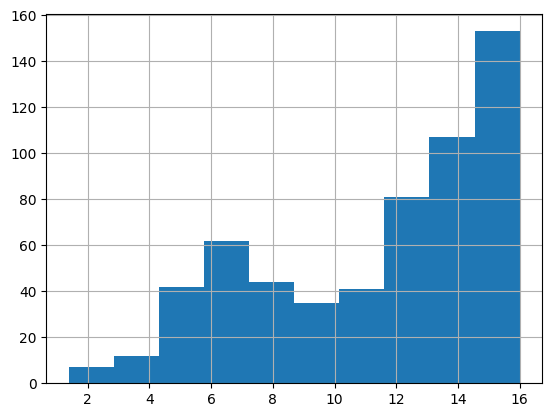

In [736]:
all_stats_agg['average_seed'].hist()

# Since we'll have to predict on combinations, we need to aggregate some stats to generate static features

In [20]:
test_case = master_df[(master_df.WTeamID == 1112) | (master_df.LTeamID == 1112)].sort_values(['Season', 'DayNum'])

In [21]:
test_case_deduped = test_case.groupby(['Season', 'DayNum'], as_index=False).first()

In [376]:
unique_teams = np.unique(master_df['WTeamID'].tolist() + master_df['LTeamID'].tolist())

In [377]:
Mens = pd.read_csv('march-machine-learning-mania-2025/MTeams.csv')['TeamID'].unique().tolist()
Womens = pd.read_csv('march-machine-learning-mania-2025/WTeams.csv')['TeamID'].unique().tolist()

In [378]:
combos = list(combinations(Mens + Womens, 2))

In [531]:
unique_teams = np.unique(Mens + Womens)

In [556]:
required_ids_df = pd.read_csv('march-machine-learning-mania-2025/SampleSubmissionStage2.csv')
required_str = required_ids_df['ID'].unique().tolist()
ids = np.unique([int(i.split('_')[1]) for i in required_ids_df['ID']] + [int(i.split('_')[2]) for i in required_ids_df['ID']])

# Get all aggs
agg_dfs = []
for i in ids:
    agg_df = pd.DataFrame(agg_team_stats(i, master_df), index=[0])
    agg_dfs.append(agg_df)

all_stats_agg = pd.concat(agg_dfs).reset_index().drop('index', axis=1).sort_values('TeamID')
all_stats_agg['TeamID'] = all_stats_agg['TeamID'].astype(int)

feature_set = ['WTeamID', 'LTeamID']
test_final = pd.DataFrame({
    'matchup': list(combinations(ids, 2))
})

In [478]:
feature_set = ['WTeamID', 'LTeamID']

In [358]:
matchups = list(combinations(unique_teams, 2))

In [476]:
len(matchups)

121278

In [565]:
feature_set = ['WTeamID', 'LTeamID']
test_final = pd.DataFrame({
    'matchup': list(combinations(ids, 2))
})


In [566]:
# this should be the logic going forward - you shouldnt make predictions iteratively!!!
test_final['min_id'] = test_final['matchup'].apply(lambda x: min(x))
test_final['max_id'] = test_final['matchup'].apply(lambda x: max(x))
test_final['matchup_str'] = '2025_' + test_final['min_id'].astype(str) + '_' + test_final['max_id'].astype(str)

In [481]:
left_features = [i.strip('W') for i in feature_set if (i.startswith('W') or i.startswith('WL'))]

In [575]:
merge1 = pd.merge(left=all_stats_agg, right=test_final, left_on='TeamID', right_on='min_id', how='left')
W_rename_dict = {i:'W'+i for i in left_features}
merge1 = merge1.rename(columns=W_rename_dict)

merge1 = pd.merge(left=all_stats_agg, right=merge1, left_on='TeamID', right_on='max_id', how='left')
L_rename_dict = {i:'L'+i for i in left_features}
merge1 = merge1.rename(columns=L_rename_dict)

In [338]:
required_ids_df = pd.read_csv('march-machine-learning-mania-2025/SampleSubmissionStage2.csv')
required_ids = list(set(required_ids_df['ID']))

In [620]:
# Get all aggs
agg_dfs = []
for i in ids:
    agg_df = pd.DataFrame(agg_team_stats(i, master_df), index=[0])
    agg_dfs.append(agg_df)

all_stats_agg = pd.concat(agg_dfs).reset_index().drop('index', axis=1).sort_values('TeamID')
all_stats_agg['TeamID'] = all_stats_agg['TeamID'].astype(int)

In [672]:
# try to build this out for 2 sets of chiral features, since logic for agg'd features isn't build yet
def forecast(model, features=['WTeamID', 'LTeamID']):
    chiral_features = [i for i in features if (i.startswith('W') or i.startswith('WL'))]
    chiral_features_stripped = [i.strip('W') for i in chiral_features]
    
    required_ids_df = pd.read_csv('march-machine-learning-mania-2025/SampleSubmissionStage2.csv')
    required_str = required_ids_df['ID'].unique().tolist()
    ids = np.unique([int(i.split('_')[1]) for i in required_ids_df['ID']] + [int(i.split('_')[2]) for i in required_ids_df['ID']])

    cleaned_df = pd.DataFrame({
        'matchup': list(combinations(ids, 2))
    })
    
    cleaned_df['min_id'] = cleaned_df['matchup'].apply(lambda x: min(x))
    cleaned_df['max_id'] = cleaned_df['matchup'].apply(lambda x: max(x))
    cleaned_df['matchup_str'] = '2025_' + cleaned_df['min_id'].astype(str) + '_' + cleaned_df['max_id'].astype(str)
    
    merge1 = pd.merge(left=all_stats_agg, right=cleaned_df, left_on='TeamID', right_on='min_id', how='left')
    W_rename_dict = {i:'W'+i for i in chiral_features_stripped}
    merge1 = merge1.rename(columns=W_rename_dict)

    merge1 = pd.merge(left=all_stats_agg, right=merge1, left_on='TeamID', right_on='max_id', how='left')
    L_rename_dict = {i:'L'+i for i in  chiral_features_stripped}
    merge1 = merge1.rename(columns=L_rename_dict)
    
    merge1 = merge1[merge1['matchup_str'].isin(required_str)]

    features_to_use = []

    for i,j in zip(list(W_rename_dict.values()), list(L_rename_dict.values())):
        features_to_use.extend([i,j])

    X_predict = merge1[features_to_use]

    preds = model.predict_proba(X_predict)[:,1]

    submission = pd.concat([merge1['matchup_str'].reset_index(), pd.DataFrame({'result':preds}).reset_index()], axis=1).drop('index', axis=1)
    submission = submission.rename(columns={'matchup_str':'ID', 'result':'Pred'})
    
    return submission

In [680]:
master_df.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'WTeamName', 'WFirstD1Season',
       'WLastD1Season', 'LTeamID', 'LScore', 'LTeamName', 'LFirstD1Season',
       'LLastD1Season', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM',
       'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM',
       'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO',
       'LStl', 'LBlk', 'LPF', 'result', 'Walltime_w', 'Walltime_l',
       'Wtotal_pts', 'Wppg', 'Wmax_scored', 'Wmin_scored', 'Wstd_dev_pts',
       'Waverage_win_margin', 'Waverage_loss_margin', 'Wlongest_run',
       'Wshortest_run', 'Wcount_yrs_tourney', 'Lalltime_w', 'Lalltime_l',
       'Ltotal_pts', 'Lppg', 'Lmax_scored', 'Lmin_scored', 'Lstd_dev_pts',
       'Laverage_win_margin', 'Laverage_loss_margin', 'Llongest_run',
       'Lshortest_run', 'Lcount_yrs_tourney'],
      dtype='object')

In [685]:
master_df.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'WTeamName', 'WFirstD1Season',
       'WLastD1Season', 'LTeamID', 'LScore', 'LTeamName', 'LFirstD1Season',
       'LLastD1Season', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM',
       'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM',
       'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO',
       'LStl', 'LBlk', 'LPF', 'result', 'Walltime_w', 'Walltime_l',
       'Wtotal_pts', 'Wppg', 'Wmax_scored', 'Wmin_scored', 'Wstd_dev_pts',
       'Waverage_win_margin', 'Waverage_loss_margin', 'Wlongest_run',
       'Wshortest_run', 'Wcount_yrs_tourney', 'Lalltime_w', 'Lalltime_l',
       'Ltotal_pts', 'Lppg', 'Lmax_scored', 'Lmin_scored', 'Lstd_dev_pts',
       'Laverage_win_margin', 'Laverage_loss_margin', 'Llongest_run',
       'Lshortest_run', 'Lcount_yrs_tourney'],
      dtype='object')

In [747]:
features = ['Wppg', 'Lppg', 'Walltime_w', 'Lalltime_w', 'Walltime_l', 'Lalltime_l', 'Wmax_scored', 'Lmax_scored', 'Wmin_scored', 'Lmin_scored', 'Waverage_seed', 'Laverage_seed']
model_to_save = bracketology(master_df, feature_set=features, model_name='xgb')
print(model_to_save)
output = forecast(model=model_to_save['model'], features=features)

{'model_name': 'xgb', 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'auc': 0.7989110794691145, 'accuracy': 0.7076010544815466, 'brier_score': 0.2036695457116922}


In [702]:
output.to_csv('/Users/benstager/Desktop/march_mania_stager_2025_v2.csv', index=False, header=True)

In [ ]:
1433 1140

In [764]:
output[output['ID'] == '2025_1208_1211']

,ID,Pred
5457,2025_1208_1211,0.001285


# Kaggle reference

In [314]:
# File path
input_folder = r"march-machine-learning-mania-2025/"


# Pertinent file names
mens_files = ["MNCAATourneyCompactResults.csv", "MRegularSeasonCompactResults.csv", "MTeams.csv"]
womens_files = ["WNCAATourneyCompactResults.csv", "WRegularSeasonCompactResults.csv", "WTeams.csv"]

dataframes = {}

# Load in csv data and cast them as dataframes
def load_csv_files(file_list):
    for file in file_list:
        file_path = os.path.join(input_folder, file)
        key = os.path.splitext(file)[0]
        try:
            dataframes[key] = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error loading {file}: {e}")

# Load mens and womens data
load_csv_files(mens_files)
load_csv_files(womens_files)

# Preprocess - the author uses a very minimal feature set so it is very easy to follow
def preprocess_results(df):
    df = df[['Season', 'WTeamID', 'LTeamID']].copy()
    df.loc[:, 'Result'] = 1  # Win label
    df_inv = df.copy()
    df_inv[['WTeamID', 'LTeamID']] = df[['LTeamID', 'WTeamID']].values
    df_inv.loc[:, 'Result'] = 0  # Loss label
    return pd.concat([df, df_inv], ignore_index=True)

# Preprocesses them into dataframes 
men_results = preprocess_results(dataframes['MNCAATourneyCompactResults'])
women_results = preprocess_results(dataframes['WNCAATourneyCompactResults'])

all_results = pd.concat([men_results, women_results], ignore_index=True)

# Merge men's and women's datasets
# all_results = pd.concat([men_results, women_results], ignore_index=True)

# Train model
X = all_results[['Season', 'WTeamID', 'LTeamID']]
y = all_results['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model is trained here - but the predictions are combinations of *all* possible pairings teams
model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=200)
model.fit(X_train, y_train)

# Evaluate model - uses a brier score?
preds = model.predict_proba(X_test)[:, 1]
print(f"Brier Score: {brier_score_loss(y_test, preds)}")

# Generate submission
all_teams = np.concatenate((dataframes['MTeams']['TeamID'].values, dataframes['WTeams']['TeamID'].values))
pairings = list(combinations(all_teams, 2))

# Load required matchup IDs
required_ids_df = pd.read_csv(os.path.join(input_folder, "SampleSubmissionStage2.csv"))
required_ids = set(required_ids_df['ID'])

# Submit to kaggle?
def create_submission(pairings, season=2025, max_rows=131407):
    submission = []
    for (team1, team2) in pairings:
        matchup_id = f"{season}_{min(team1, team2)}_{max(team1, team2)}"
        if matchup_id in required_ids:
            input_data = pd.DataFrame({'Season': [season], 'WTeamID': [min(team1, team2)], 'LTeamID': [max(team1, team2)]})
            pred = model.predict_proba(input_data)[0, 1] if len(input_data) > 0 else 0.5
            submission.append([matchup_id, pred])
    submission_df = pd.DataFrame(submission, columns=["ID", "Pred"])
    print(f"Submission file has {submission_df.shape[0]} rows.")
    return submission_df


0:	learn: 0.6918448	total: 2.28ms	remaining: 2.28s
200:	learn: 0.5864456	total: 223ms	remaining: 887ms
400:	learn: 0.5174959	total: 480ms	remaining: 717ms
600:	learn: 0.4707636	total: 706ms	remaining: 469ms
800:	learn: 0.4331983	total: 932ms	remaining: 231ms
999:	learn: 0.4016661	total: 1.16s	remaining: 0us
Brier Score: 0.2188024186822397
